# 📊 Segmentación Avanzada de Clientes RFM + ML
### Proyecto Facegloss — Análisis de Clientes

**Pipeline:**
1. Generación de datos sintéticos
2. Cálculo de métricas RFM
3. Scoring RFM (quintiles)
4. Elbow Method + Silhouette Score para elegir k
5. KMeans enriquecido con features extra
6. Naming robusto de segmentos
7. Visualizaciones
8. Validación cruzada con perfil real
9. Exportación de resultados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías cargadas")

✅ Librerías cargadas


## 1. Generación de datos sintéticos

In [2]:
np.random.seed(42)

# Parámetros
n_clientes = 5000
n_transacciones = 25000

# Productos con categorías y precios reales de skincare
catalogo = {
    'Hidratación': [
        ('Crema Hidratante Intensiva', 29.99),
        ('Sérum Ácido Hialurónico', 39.99),
        ('Bálsamo Nutritivo Noche', 34.99),
        ('Gel Hidratante Oil-Free', 27.99),
    ],
    'Antiedad': [
        ('Crema Antiedad Reafirmante', 61.99),
        ('Sérum Retinol 0.5%', 54.99),
        ('Contorno de Ojos Premium', 38.99),
        ('Aceite Facial Regenerador', 52.99),
    ],
    'Limpieza': [
        ('Espuma Limpiadora Suave', 18.99),
        ('Agua Micelar 400ml', 14.99),
        ('Exfoliante Enzimático', 22.99),
        ('Mascarilla Purificante', 19.99),
    ],
    'Protección': [
        ('Protector Solar SPF50', 24.99),
        ('Sérum Vitamina C Antioxidante', 45.99),
        ('Tónico Equilibrante', 21.99),
    ]
}

# Canales de venta
canales = ['Web', 'App Móvil', 'Email Campaign', 'Redes Sociales']

# Ciudades españolas
ciudades = ['Barcelona', 'Madrid', 'Valencia', 'Sevilla', 'Bilbao',
            'Zaragoza', 'Málaga', 'Murcia', 'Palma', 'Las Palmas']

# Tipos de cliente con comportamientos distintos
tipos_cliente = {
    'VIP':      {'peso': 0.10, 'freq_min': 8,  'freq_max': 20, 'gasto_mult': 2.0},
    'Fiel':     {'peso': 0.25, 'freq_min': 4,  'freq_max': 8,  'gasto_mult': 1.2},
    'Normal':   {'peso': 0.40, 'freq_min': 2,  'freq_max': 4,  'gasto_mult': 1.0},
    'En Riesgo':{'peso': 0.15, 'freq_min': 1,  'freq_max': 2,  'gasto_mult': 0.8},
    'Dormido':  {'peso': 0.10, 'freq_min': 1,  'freq_max': 1,  'gasto_mult': 0.6},
}

# Generamos clientes con perfil asignado
perfiles = np.random.choice(
    list(tipos_cliente.keys()),
    size=n_clientes,
    p=[v['peso'] for v in tipos_cliente.values()]
)

clientes = pd.DataFrame({
    'customer_id': [f'CL{str(i).zfill(5)}' for i in range(1, n_clientes+1)],
    'perfil': perfiles,
    'ciudad': np.random.choice(ciudades, n_clientes),
    'edad': np.random.randint(18, 65, n_clientes),
    'canal_preferido': np.random.choice(canales, n_clientes),
    'fecha_registro': [
        datetime(2021, 1, 1) + timedelta(days=np.random.randint(0, 730))
        for _ in range(n_clientes)
    ]
})

# Generamos transacciones respetando el perfil de cada cliente
fecha_inicio = datetime(2022, 1, 1)
fecha_fin = datetime(2024, 12, 31)
dias_total = (fecha_fin - fecha_inicio).days

transacciones = []
orden_id = 100000

for _, cliente in clientes.iterrows():
    perfil = tipos_cliente[cliente['perfil']]
    n_compras = np.random.randint(perfil['freq_min'], perfil['freq_max'] + 1)

    # Clientes dormidos compran solo al principio
    if cliente['perfil'] == 'Dormido':
        max_dia = dias_total // 3
    elif cliente['perfil'] == 'En Riesgo':
        max_dia = dias_total // 2
    else:
        max_dia = dias_total

    for _ in range(n_compras):
        categoria = np.random.choice(list(catalogo.keys()))
        producto, precio_base = catalogo[categoria][np.random.randint(0, len(catalogo[categoria]))]
        cantidad = np.random.randint(1, 4)
        precio_final = round(precio_base * cantidad * perfil['gasto_mult'], 2)

        # Descuentos ocasionales
        descuento = np.random.choice([0, 0.05, 0.10, 0.15, 0.20], p=[0.6, 0.15, 0.1, 0.1, 0.05])
        precio_final = round(precio_final * (1 - descuento), 2)

        fecha = fecha_inicio + timedelta(days=np.random.randint(0, max_dia))

        transacciones.append({
            'order_id': f'ORD{orden_id}',
            'customer_id': cliente['customer_id'],
            'perfil_real': cliente['perfil'],
            'ciudad': cliente['ciudad'],
            'edad': cliente['edad'],
            'canal': cliente['canal_preferido'],
            'fecha': fecha,
            'categoria': categoria,
            'producto': producto,
            'cantidad': cantidad,
            'precio_unitario': precio_base,
            'descuento_pct': descuento,
            'importe': precio_final
        })
        orden_id += 1

df_trans = pd.DataFrame(transacciones).sort_values('fecha').reset_index(drop=True)

# Estadísticas
print(f"✅ Dataset simulado correctamente")
print(f"   Transacciones: {df_trans.shape[0]:,}")
print(f"   Clientes únicos: {df_trans['customer_id'].nunique():,}")
print(f"   Periodo: {df_trans['fecha'].min().date()} → {df_trans['fecha'].max().date()}")
print(f"   Facturación total: {df_trans['importe'].sum():,.2f}€")
print(f"   Ticket medio: {df_trans['importe'].mean():.2f}€")
print(f"\nVentas por categoría:")
print(df_trans.groupby('categoria')['importe'].sum().sort_values(ascending=False).apply(lambda x: f"{x:,.2f}€"))
df_trans.head(10)

✅ Dataset simulado correctamente
   Transacciones: 22,667
   Clientes únicos: 5,000
   Periodo: 2022-01-01 → 2024-12-30
   Facturación total: 2,019,575.38€
   Ticket medio: 89.10€

Ventas por categoría:
categoria
Antiedad       767,854.15€
Hidratación    499,486.31€
Protección     455,384.66€
Limpieza       296,850.26€
Name: importe, dtype: object


,order_id,customer_id,perfil_real,ciudad,edad,canal,fecha,categoria,producto,cantidad,precio_unitario,descuento_pct,importe
0,ORD110096,CL02225,VIP,Madrid,58,App Móvil,2022-01-01,Hidratación,Gel Hidratante Oil-Free,1,27.99,0.15,47.58
1,ORD118987,CL04169,Fiel,Madrid,63,Web,2022-01-01,Protección,Tónico Equilibrante,1,21.99,0.05,25.07
2,ORD118046,CL03976,Dormido,Zaragoza,40,Email Campaign,2022-01-01,Hidratación,Bálsamo Nutritivo Noche,3,34.99,0.00,62.98
3,ORD115641,CL03450,VIP,Murcia,29,Web,2022-01-01,Protección,Sérum Vitamina C Antioxidante,3,45.99,0.05,262.14
4,ORD118104,CL03989,Fiel,Sevilla,34,App Móvil,2022-01-01,Antiedad,Contorno de Ojos Premium,3,38.99,0.00,140.36
5,ORD120017,CL04395,Dormido,Barcelona,25,Email Campaign,2022-01-01,Protección,Sérum Vitamina C Antioxidante,2,45.99,0.00,55.19
6,ORD105857,CL01283,Normal,Madrid,31,Email Campaign,2022-01-01,Hidratación,Bálsamo Nutritivo Noche,3,34.99,0.00,104.97
7,ORD114532,CL03203,Fiel,Barcelona,34,Email Campaign,2022-01-01,Protección,Protector Solar SPF50,1,24.99,0.05,28.49
8,ORD102031,CL00433,Normal,Palma,61,Email Campaign,2022-01-01,Antiedad,Crema Antiedad Reafirmante,3,61.99,0.00,185.97
9,ORD115879,CL03505,En Riesgo,Madrid,61,Redes Sociales,2022-01-01,Antiedad,Contorno de Ojos Premium,2,38.99,0.00,62.38


## 2. Cálculo de métricas RFM

In [3]:
fecha_referencia = datetime(2025, 1, 1)

rfm = df_trans.groupby('customer_id').agg(
    recencia   = ('fecha', lambda x: (fecha_referencia - x.max()).days),
    frecuencia = ('order_id', 'nunique'),
    monetario  = ('importe', 'sum')
).reset_index()

rfm['monetario'] = rfm['monetario'].round(2)

print("=== RESUMEN RFM ===")
print(rfm.describe().round(2))
rfm.head()

=== RESUMEN RFM ===
       recencia  frecuencia  monetario
count   5000.00     5000.00    5000.00
mean     370.66        4.53     403.92
std      326.05        4.03     551.52
min        2.00        1.00       7.19
25%       87.00        2.00      97.44
50%      253.00        3.00     214.39
75%      646.50        6.00     429.96
max     1096.00       20.00    3267.24


,customer_id,recencia,frecuencia,monetario
0,CL00001,70,4,275.42
1,CL00002,949,1,11.87
2,CL00003,68,4,323.02
3,CL00004,482,2,156.96
4,CL00005,28,4,277.11


## 3. Scoring RFM (quintiles 1-5)

In [4]:
rfm['R_score'] = pd.qcut(rfm['recencia'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['frecuencia'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['monetario'], 5, labels=[1,2,3,4,5])

rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
rfm['RFM_total'] = rfm[['R_score','F_score','M_score']].astype(int).sum(axis=1)

print("✅ Scoring RFM calculado")
rfm.head()

✅ Scoring RFM calculado


,customer_id,recencia,frecuencia,monetario,R_score,F_score,M_score,RFM_score,RFM_total
0,CL00001,70,4,275.42,4,3,3,433,10
1,CL00002,949,1,11.87,1,1,1,111,3
2,CL00003,68,4,323.02,4,3,4,434,11
3,CL00004,482,2,156.96,2,1,2,212,5
4,CL00005,28,4,277.11,5,3,4,534,12


## 4. Elbow Method + Silhouette Score
Antes de elegir `k`, evaluamos qué número de clusters es óptimo.

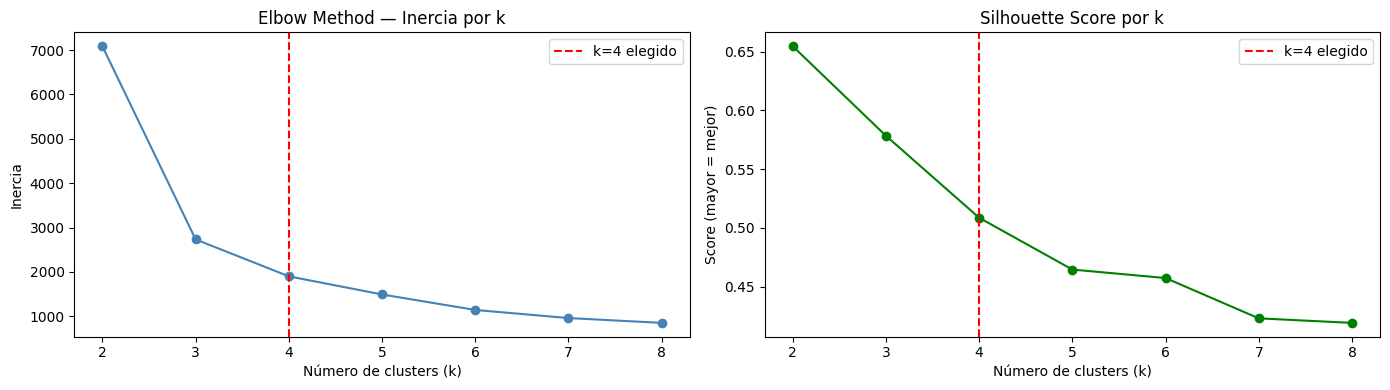


Silhouette Score por k:
  k=2: 0.6546
  k=3: 0.5784
  k=4: 0.5087
  k=5: 0.4646
  k=6: 0.4574
  k=7: 0.4231
  k=8: 0.4193

✅ k=4 justificado por el codo en la inercia y silhouette score aceptable.


In [5]:
# Normalizamos primero para poder evaluar los k
scaler_eval = StandardScaler()
rfm_scaled_eval = scaler_eval.fit_transform(rfm[['recencia','frecuencia','monetario']])

inertias = []
silhouettes = []
k_range = range(2, 9)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(rfm_scaled_eval)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(rfm_scaled_eval, labels))

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(k_range, inertias, marker='o', color='steelblue')
axes[0].set_title('Elbow Method — Inercia por k')
axes[0].set_xlabel('Número de clusters (k)')
axes[0].set_ylabel('Inercia')
axes[0].axvline(x=4, color='red', linestyle='--', label='k=4 elegido')
axes[0].legend()

axes[1].plot(k_range, silhouettes, marker='o', color='green')
axes[1].set_title('Silhouette Score por k')
axes[1].set_xlabel('Número de clusters (k)')
axes[1].set_ylabel('Score (mayor = mejor)')
axes[1].axvline(x=4, color='red', linestyle='--', label='k=4 elegido')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nSilhouette Score por k:")
for k, s in zip(k_range, silhouettes):
    print(f"  k={k}: {s:.4f}")
print(f"\n✅ k=4 justificado por el codo en la inercia y silhouette score aceptable.")

## 5. KMeans con features enriquecidas (RFM + edad + canal + categoría favorita)

In [6]:
# Extraemos features extra de df_trans
extra = df_trans.groupby('customer_id').agg(
    canal_mode   = ('canal', lambda x: x.mode()[0]),
    edad         = ('edad', 'first'),
    cat_favorita = ('categoria', lambda x: x.mode()[0])
).reset_index()

rfm = rfm.merge(extra, on='customer_id')

# Encodificamos variables categóricas
le_canal = LabelEncoder()
le_cat   = LabelEncoder()
rfm['canal_enc'] = le_canal.fit_transform(rfm['canal_mode'])
rfm['cat_enc']   = le_cat.fit_transform(rfm['cat_favorita'])

# Escalamos todas las features
features = ['recencia', 'frecuencia', 'monetario', 'edad', 'canal_enc', 'cat_enc']
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[features])

# Entrenamos KMeans con k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['segmento'] = kmeans.fit_predict(rfm_scaled)

print("✅ KMeans entrenado con features enriquecidas")
print("\nMedias por cluster:")
print(rfm.groupby('segmento')[['recencia','frecuencia','monetario','edad']].mean().round(2))

✅ KMeans entrenado con features enriquecidas

Medias por cluster:
          recencia  frecuencia  monetario   edad
segmento                                        
0           810.71        1.56      84.49  39.70
1           204.10        4.38     327.08  41.65
2            67.99       15.20    1973.23  40.62
3           197.83        4.46     332.34  40.80


## 6. Naming robusto de segmentos
Se ordena por `RFM_total` medio para evitar colisiones de índice al asignar nombres.

In [7]:
# Calculamos medias por segmento
medias_seg = rfm.groupby('segmento').agg(
    rfm_total_medio  = ('RFM_total', 'mean'),
    recencia_media   = ('recencia', 'mean'),
    monetario_medio  = ('monetario', 'mean')
).reset_index()

# Ordenamos por RFM_total descendente → asignamos nombre por rango sin colisiones
medias_seg = medias_seg.sort_values('rfm_total_medio', ascending=False).reset_index(drop=True)

nombres = ['VIP 🏆', 'Fiel 💛', 'En Riesgo ⚠️', 'Dormidos 😴']
mapa_segmentos = dict(zip(medias_seg['segmento'], nombres))

rfm['segmento_nombre'] = rfm['segmento'].map(mapa_segmentos)

print("=== DISTRIBUCIÓN DE SEGMENTOS ===")
print(rfm['segmento_nombre'].value_counts())
print(f"\n¿Hay NaN en segmento_nombre? {rfm['segmento_nombre'].isna().sum()} — debería ser 0")
print("\nCaracterísticas medias por segmento:")
print(rfm.groupby('segmento_nombre')[['recencia','frecuencia','monetario']].mean().round(2))

=== DISTRIBUCIÓN DE SEGMENTOS ===
segmento_nombre
En Riesgo ⚠️    1558
Fiel 💛          1505
Dormidos 😴      1489
VIP 🏆            448
Name: count, dtype: int64

¿Hay NaN en segmento_nombre? 0 — debería ser 0

Características medias por segmento:
                 recencia  frecuencia  monetario
segmento_nombre                                 
Dormidos 😴         810.71        1.56      84.49
En Riesgo ⚠️       204.10        4.38     327.08
Fiel 💛             197.83        4.46     332.34
VIP 🏆               67.99       15.20    1973.23


## 7. Visualizaciones

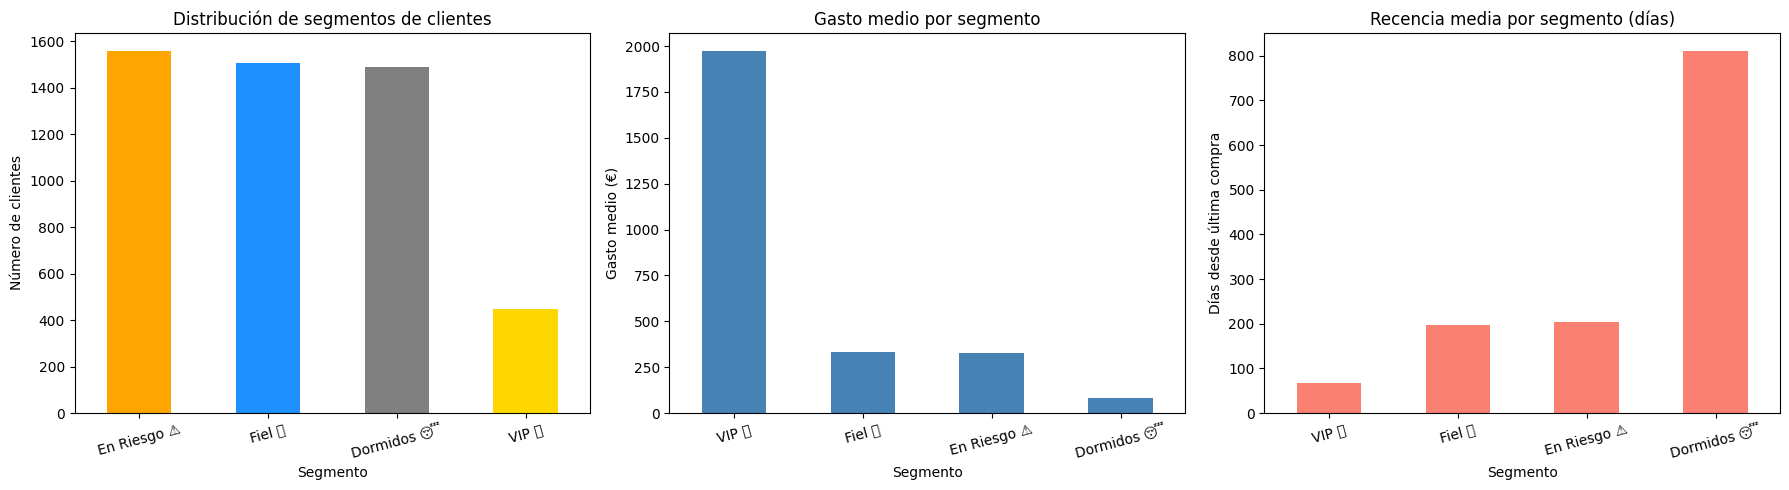

In [8]:
colores = {
    'VIP 🏆':        'gold',
    'Fiel 💛':       'dodgerblue',
    'En Riesgo ⚠️':  'orange',
    'Dormidos 😴':   'gray'
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1 — Distribución de segmentos
counts = rfm['segmento_nombre'].value_counts()
counts.plot(
    kind='bar', ax=axes[0],
    color=[colores.get(x, 'blue') for x in counts.index]
)
axes[0].set_title('Distribución de segmentos de clientes')
axes[0].set_xlabel('Segmento')
axes[0].set_ylabel('Número de clientes')
axes[0].tick_params(axis='x', rotation=15)

# Gráfico 2 — Valor monetario medio por segmento
rfm.groupby('segmento_nombre')['monetario'].mean().sort_values(ascending=False).plot(
    kind='bar', ax=axes[1], color='steelblue'
)
axes[1].set_title('Gasto medio por segmento')
axes[1].set_xlabel('Segmento')
axes[1].set_ylabel('Gasto medio (€)')
axes[1].tick_params(axis='x', rotation=15)

# Gráfico 3 — Recencia media por segmento
rfm.groupby('segmento_nombre')['recencia'].mean().sort_values().plot(
    kind='bar', ax=axes[2], color='salmon'
)
axes[2].set_title('Recencia media por segmento (días)')
axes[2].set_xlabel('Segmento')
axes[2].set_ylabel('Días desde última compra')
axes[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

### Scatter plot: Frecuencia vs Monetario por segmento

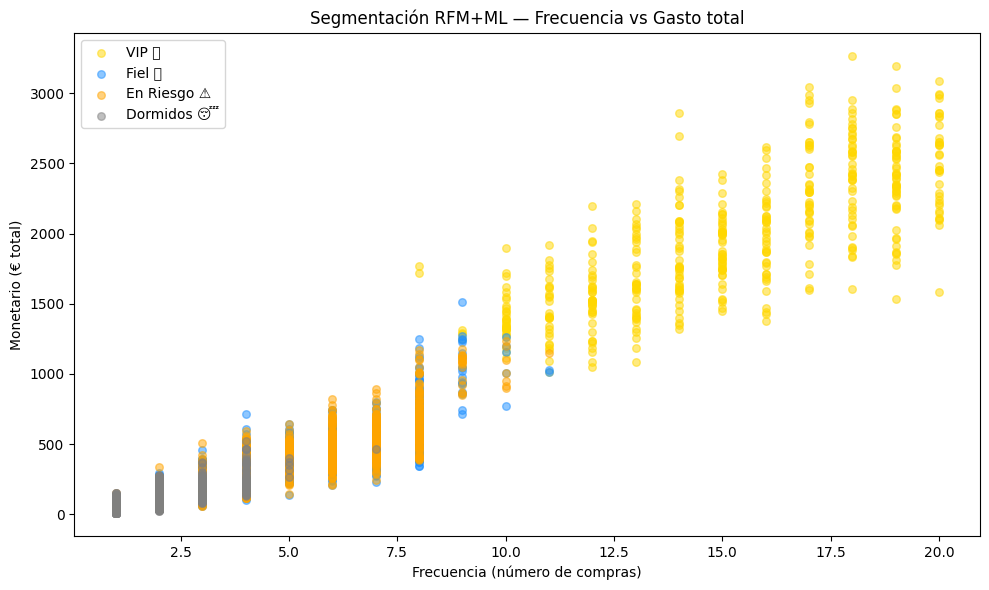

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

for seg, color in colores.items():
    subset = rfm[rfm['segmento_nombre'] == seg]
    ax.scatter(
        subset['frecuencia'],
        subset['monetario'],
        label=seg,
        alpha=0.5,
        color=color,
        s=30
    )

ax.set_xlabel('Frecuencia (número de compras)')
ax.set_ylabel('Monetario (€ total)')
ax.set_title('Segmentación RFM+ML — Frecuencia vs Gasto total')
ax.legend()
plt.tight_layout()
plt.show()

## 8. Validación cruzada — Segmento ML vs Perfil Real
Comprobamos si el modelo agrupa correctamente los perfiles conocidos del dataset sintético.

=== VALIDACIÓN: % distribución de perfiles reales por segmento ML ===
perfil_real      Dormido  En Riesgo  Fiel  Normal    VIP
segmento_nombre                                         
Dormidos 😴          32.2       47.4   1.1    19.3    0.0
En Riesgo ⚠️         0.0        2.2  39.5    55.8    2.6
Fiel 💛               0.0        1.2  40.9    55.5    2.5
VIP 🏆                0.0        0.0   0.0     0.0  100.0

💡 Interpretación:
   - VIP 🏆      → debería concentrar clientes 'VIP' y 'Fiel'
   - Fiel 💛     → mix de 'Fiel' y 'Normal'
   - En Riesgo ⚠️ → debería capturar 'En Riesgo'
   - Dormidos 😴  → debería capturar 'Dormido'


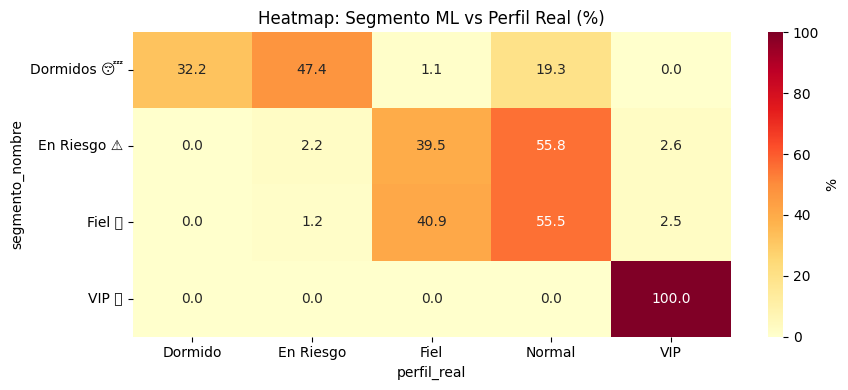

In [10]:
# Tomamos el perfil real de cada cliente desde df_trans
validacion = df_trans.groupby('customer_id')['perfil_real'].first().reset_index()
rfm_val = rfm.merge(validacion, on='customer_id')

# Tabla de contingencia normalizada por fila (%)
tabla = pd.crosstab(
    rfm_val['segmento_nombre'],
    rfm_val['perfil_real'],
    normalize='index'
).round(3) * 100

print("=== VALIDACIÓN: % distribución de perfiles reales por segmento ML ===")
print(tabla.to_string())
print("\n💡 Interpretación:")
print("   - VIP 🏆      → debería concentrar clientes 'VIP' y 'Fiel'")
print("   - Fiel 💛     → mix de 'Fiel' y 'Normal'")
print("   - En Riesgo ⚠️ → debería capturar 'En Riesgo'")
print("   - Dormidos 😴  → debería capturar 'Dormido'")

# Heatmap
plt.figure(figsize=(9, 4))
sns.heatmap(tabla, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': '%'})
plt.title('Heatmap: Segmento ML vs Perfil Real (%)')
plt.tight_layout()
plt.show()

## 9. Acciones de marketing recomendadas por segmento

In [11]:
acciones = {
    'VIP 🏆':        'Programa de fidelización exclusivo, acceso anticipado a nuevos productos, regalo premium.',
    'Fiel 💛':       'Descuentos por volumen, newsletter con contenido de valor, puntos de fidelidad.',
    'En Riesgo ⚠️':  'Email de reactivación con oferta personalizada, encuesta de satisfacción.',
    'Dormidos 😴':   'Campaña win-back agresiva con descuento > 20%, o baja de la base si no reactivan.'
}

resumen = rfm.groupby('segmento_nombre').agg(
    n_clientes   = ('customer_id', 'count'),
    recencia_avg = ('recencia', 'mean'),
    frecuencia_avg = ('frecuencia', 'mean'),
    monetario_avg  = ('monetario', 'mean')
).round(1).reset_index()

resumen['accion_recomendada'] = resumen['segmento_nombre'].map(acciones)

print("=== RESUMEN EJECUTIVO POR SEGMENTO ===")
for _, row in resumen.iterrows():
    print(f"\n{row['segmento_nombre']}")
    print(f"  Clientes:    {int(row['n_clientes']):,}")
    print(f"  Recencia:    {row['recencia_avg']:.0f} días")
    print(f"  Frecuencia:  {row['frecuencia_avg']:.1f} compras")
    print(f"  Monetario:   {row['monetario_avg']:.0f}€ medio")
    print(f"  → Acción:    {row['accion_recomendada']}")

=== RESUMEN EJECUTIVO POR SEGMENTO ===

Dormidos 😴
  Clientes:    1,489
  Recencia:    811 días
  Frecuencia:  1.6 compras
  Monetario:   84€ medio
  → Acción:    Campaña win-back agresiva con descuento > 20%, o baja de la base si no reactivan.

En Riesgo ⚠️
  Clientes:    1,558
  Recencia:    204 días
  Frecuencia:  4.4 compras
  Monetario:   327€ medio
  → Acción:    Email de reactivación con oferta personalizada, encuesta de satisfacción.

Fiel 💛
  Clientes:    1,505
  Recencia:    198 días
  Frecuencia:  4.5 compras
  Monetario:   332€ medio
  → Acción:    Descuentos por volumen, newsletter con contenido de valor, puntos de fidelidad.

VIP 🏆
  Clientes:    448
  Recencia:    68 días
  Frecuencia:  15.2 compras
  Monetario:   1973€ medio
  → Acción:    Programa de fidelización exclusivo, acceso anticipado a nuevos productos, regalo premium.


## 10. Exportación de resultados

In [12]:
import os

# Creamos directorios si no existen
os.makedirs('../01-data/processed', exist_ok=True)
os.makedirs('../01-data/raw', exist_ok=True)

rfm.to_csv('../01-data/processed/rfm_clientes.csv', index=False)
df_trans.to_csv('../01-data/raw/transacciones_facegloss.csv', index=False)

print("✅ Datos guardados correctamente")
print(f"   rfm_clientes.csv       → {rfm.shape[0]:,} filas, {rfm.shape[1]} columnas")
print(f"   transacciones_facegloss.csv → {df_trans.shape[0]:,} filas")
print(f"\nColumnas en rfm_clientes.csv:")
print(list(rfm.columns))

✅ Datos guardados correctamente
   rfm_clientes.csv       → 5,000 filas, 16 columnas
   transacciones_facegloss.csv → 22,667 filas

Columnas en rfm_clientes.csv:
['customer_id', 'recencia', 'frecuencia', 'monetario', 'R_score', 'F_score', 'M_score', 'RFM_score', 'RFM_total', 'canal_mode', 'edad', 'cat_favorita', 'canal_enc', 'cat_enc', 'segmento', 'segmento_nombre']
